# Fig. 4m, Extended Data Fig. 5k
## Response prediction

For "Network-level encoding of local neurotransmitters in cortical astrocytes" (Cahill et al. 2024)

---

## Setup

#### Imports

In [1]:
# Typing

from typing import (
    Optional,
    Union,
    Any,
)
from matplotlib.pyplot import (
    Axes,
)
from numpy.typing import(
    ArrayLike,
    NDArray,
)
from pandas import (
    DataFrame,
)

# Others

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

# Internal

from uncaging import (
    Helper,
)

import uncaging.utils as uutils
import uncaging.events as uevents
import uncaging.plot as uplot
import uncaging.stats as ustats

#### Parameters

In [2]:
params_path = Path( 'config' ) / 'panels' / 'net_astro-4m_s5k.yaml'
params = uutils.load_params( params_path )

# Choices for `variant`:
# * 'wt' - Fig. 4m, Ext. Data Fig. 5k
variant = 'wt'

params.update( params['variants'][variant] )

#### Initial setup

In [3]:
helper = Helper(
    config_path = params['helper_configs'],
    hive_root = params['hive_root'],
    output_to = params['output_parent'],
)

# For reproducible results with randomness
np.random.seed( params['random_seed'] )

# Output saving
notebook_stem = params['notebook_stem']
analysis = params['analysis']

save_figure = helper.figure_saver( notebook_stem, analysis )
save_data = helper.data_saver( notebook_stem, analysis )
save_csv = helper.csv_saver( notebook_stem, analysis )

---

## Load data

In [4]:
events_analyze = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 29.88it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 43.81it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:01<00:00, 30.82it/s] 



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment GABA
    Excluded cells: 154
    Included cells: 164



In [5]:
events_analyze, events_prop, events_no_prop = uevents.split_events_prop(
    events_analyze,
    threshold = params['prop_threshold'],
)

---

## Analysis

### Setup

In [6]:
# These are keys we might need for downstream coregistration
keep_keys = [
    'cell_global_coreg',
    'condition',
    'dataset_id_all',
]

params['responders']['keep_keys'] = keep_keys
params['features']['keep_keys'] = keep_keys
params['rates']['keep_keys'] = keep_keys

if 'group_key' not in params['prediction']:
    if 'group_key' in params:
        params['prediction']['group_key'] = params['group_key']
    else:
        raise Exception( 'No way to infer prediction group key' )

# TODO: These have duplication with 4H

#### Statistic functions

In [7]:
def stat_ratio_active( df: DataFrame ) -> float:
    """
    TODO
    """
    return np.sum( df['ratio_active'] ) / df.shape[0]

def stat_ratio_active_diff_paired(
        df1: DataFrame,
        df2: DataFrame,
        pair_key: str = 'dataset_id'
    ) -> float:
    """
    TODO
    """

    groups_1 = df1[pair_key].unique()
    groups_2 = df2[pair_key].unique()
    groups = list( set( groups_1 ) | set( groups_2 ) )
    
    x = []
    y = []
    
    for i, group in enumerate( groups ):
        df1_group = df1[df1[pair_key] == group]
        df2_group = df2[df2[pair_key] == group]
        
        if df1_group.shape[0] == 0 or df2_group.shape[0] == 0:
            continue
        
        x.append( stat_ratio_active( df1_group ) )
        y.append( stat_ratio_active( df2_group ) )
    
    x = np.array( x )
    y = np.array( y )
    
    return np.mean( y - x )

def similarity_jaccard(
        x: ArrayLike,
        y: ArrayLike
    ) -> float:
    """
    TODO
    """
    return np.sum( (x == 1) & (y == 1) ) / np.sum( (x == 1) | (y == 1) )

In [8]:
def split_data(
        df: DataFrame,
        key: str,
        midpoint: Optional[float]
    ) -> 'tuple[DataFrame, DataFrame]':
    """
    TODO
    """

    if midpoint is None:
        filter_high = df[key] > 0
        return df[~filter_high], df[filter_high]
    
    filter_low = df[key] < midpoint
    return df[filter_low], df[~filter_low]

def response_frac_stat( df: DataFrame ) -> float:
    """TODO"""
    return np.sum( df['ratio_active'] ) / df.shape[0]

def response_frac_stat_agg(
        df: DataFrame,
        aggregate_key: Optional[str] = None,
        return_aggregates: bool = False,
    ) -> Union[float, 'tuple[float, DataFrame]']:
    """TODO"""
    
    if aggregate_key is None:
        ret = response_frac_stat( df )
        if return_aggregates:
            return ret, None
        return ret

    df_agg_data = []
    for k, df_cur in df.groupby( aggregate_key ):
        df_agg_data.append( {
            aggregate_key: k,
            'n': df_cur.shape[0],
            'stat': response_frac_stat( df_cur ),
        } )
    df_agg = pd.DataFrame( df_agg_data )
    ret = np.mean( df_agg['stat'] )

    if return_aggregates:
        return ret, df_agg

    return ret

def response_frac_diff_stat(
        df: DataFrame,
        key: str,
        aggregate_key: Optional[str] = None,
        midpoint: Optional[float] = None,
    ) -> float:
    """TODO"""

    df_low, df_high = split_data( df, key, midpoint )

    if aggregate_key is None:
        return response_frac_stat( df_low ) - response_frac_stat( df_high )

    # Aggregate key is specified
    df_agg_low_data = []
    for k, df_cur in df_low.groupby( aggregate_key ):
        df_agg_low_data.append( {
            aggregate_key: k,
            'n': df_cur.shape[0],
            'stat': response_frac_stat( df_cur ),
        } )
    df_agg_high_data = []
    for k, df_cur in df_high.groupby( aggregate_key ):
        df_agg_high_data.append( {
            aggregate_key: k,
            'n': df_cur.shape[0],
            'stat': response_frac_stat( df_cur ),
        } )
    
    df_agg_low = pd.DataFrame( df_agg_low_data, index = None )
    df_agg_high = pd.DataFrame( df_agg_high_data, index = None )

    df_agg = pd.merge( 
        df_agg_low, df_agg_high,
        on = aggregate_key,
        how = 'outer',
        suffixes = ['_low', '_high'],
    )
    return np.nanmean( df_agg['stat_low'] ) - np.nanmean( df_agg['stat_high'] )
    # return np.nanmean( df_agg['stat_low'] - df_agg['stat_high'] )

#### Main analysis

In [9]:
PredictionResult = 'dict[str, Any]'

def analyze_prediction(
        responses: DataFrame,
        features: DataFrame,
        prediction_key: str,
        group_key: str = 'cell_global',
        aggregate_key: Optional[str] = None,
        condition_key: str = 'condition',
        conditions: list = ['GABA', 'Glu'],
        quantile_split: float = 0.5,
        n_boot: int = 200,
        hierarchy_boot: 'list[str]' = ['dataset_id_all', 'cell_global_all'],
        n_perm: int = 1000,
        verbose: bool = True
    ) -> PredictionResult:
    """
    TODO
    """
    
    ret = dict()
    
    for i_condition, condition in enumerate( conditions ):
        
        cur_ret = dict()
        
        filter_condition_features = features[condition_key] == condition
        filter_condition_responses = responses[condition_key] == condition
        
        data_combined = pd.merge(
            features[filter_condition_features], responses[filter_condition_responses],
            suffixes = [None, '__copy_responses'],
            on = group_key
        )

        if quantile_split is None:
            split_point = None
        else:
            features_split = data_combined[prediction_key]
            split_point = np.nanquantile( features_split, quantile_split )
            if verbose:
                print( f'{condition}: {split_point}' )
        
        stat = lambda df: response_frac_stat_agg(
            df,
            aggregate_key = aggregate_key,
        )
        stat_diff = lambda df: response_frac_diff_stat(
            df,
            prediction_key,
            aggregate_key = aggregate_key,
            midpoint = split_point,
        )

        # Stat values
        data_low, data_high = split_data(
            data_combined,
            prediction_key,
            split_point,
        )

        cur_ret['data_low'] = data_low
        cur_ret['data_high'] = data_high
        
        cur_ret['fraction_low'] = stat( data_low )
        cur_ret['fraction_high'] = stat( data_high )
        
        cur_ret['fraction_diff'] = stat_diff( data_combined )

        # Bootstrapping
        fraction_low_boot = ustats.bootstrap_stat_hierarchical(
            stat,
            data_low,
            hierarchy_boot,
            n = n_boot,
            verbose = verbose,
        )
        fraction_high_boot = ustats.bootstrap_stat_hierarchical(
            stat,
            data_high, 
            hierarchy_boot,
            n = n_boot,
            verbose = verbose,
        )
        cur_ret['fraction_low_boot'] = fraction_low_boot
        cur_ret['fraction_high_boot'] = fraction_high_boot
        
        # Permutation testing
        fraction_diff_perm = np.zeros( (n_perm,) )
        
        it = range( n_perm )
        if verbose:
            it = tqdm( it )
        for i_perm in it:
            data_combined_perm = data_combined.copy()
            data_combined_perm[prediction_key] = np.random.permutation( data_combined_perm[prediction_key] )
            fraction_diff_perm[i_perm] = stat_diff( data_combined_perm )
            
        cur_ret['fraction_diff_perm'] = fraction_diff_perm
            
        p_perm = ustats.perm_p(
            np.sum( np.abs( fraction_diff_perm ) >= np.abs( cur_ret['fraction_diff'] ) ),
            n_perm
        )
        cur_ret['p_perm'] = p_perm
        
        ret[condition] = cur_ret
    
    return ret

#### Plotting

In [10]:
def plot_prediction(
        ax: Axes,
        results: PredictionResult,
        order: list,
        quantile: float = 0.05,
        bar_width: float = 0.4,
        error_linewidth: float = 2,
        significance_offset: float = 0.05
    ):
    """
    TODO
    """
    
    xticks = []
    xticklabels = []
    
    total_occupied = 2. * bar_width
    total_unoccupied = 1. - total_occupied
    spacing = total_unoccupied / 2.
    center_offset = (spacing / 2.) + (bar_width / 2.)
    
    for i_condition, condition in enumerate( order ):
        
        result = results[condition]
        
        #
        
        if quantile is None:
            std_low = np.std( result['fraction_low_boot'] )
            fraction_low_low = result['fraction_low'] - std_low
            fraction_low_high = result['fraction_low'] + std_low
            
            std_high = np.std( result['fraction_high_boot'] )
            fraction_high_low = result['fraction_high'] - std_high
            fraction_high_high = result['fraction_high'] + std_high
            
        else:
            fraction_low_low = np.quantile( result['fraction_low_boot'], quantile/2. )
            fraction_low_high = np.quantile( result['fraction_low_boot'], 1. - (quantile/2.) )
            
            fraction_high_low = np.quantile( result['fraction_high_boot'], quantile/2. )
            fraction_high_high = np.quantile( result['fraction_high_boot'], 1. - (quantile/2.) )
        
        #
        
        x_cur = i_condition - center_offset
        
        ax.bar( x_cur, result['fraction_low'],
                width = bar_width,
                color = helper.condition_colors[condition],
                alpha = 0.5 )
        ax.plot( [x_cur, x_cur], [fraction_low_low, fraction_low_high], 'k-',
                 linewidth = error_linewidth )
        
        xticks.append( x_cur )
        xticklabels.append( 'Low' )
        
        #
        
        x_cur = i_condition
        
        ax.text( x_cur,
                 significance_offset + np.maximum( fraction_low_high,
                                                   fraction_high_high ),
                 uutils.p_text( result['p_perm'] ),
                 horizontalalignment = 'center',
                 verticalalignment = 'baseline',
                 color = helper.condition_colors[condition] )
        
        #
        
        x_cur = i_condition + center_offset
        
        ax.bar( x_cur, result['fraction_high'],
                width = bar_width,
                color = helper.condition_colors[condition],
                alpha = 1. )
        ax.plot( [x_cur, x_cur], [fraction_high_low, fraction_high_high], 'k-',
                 linewidth = 2 )
        
        xticks.append( x_cur )
        xticklabels.append( 'High' )
    
    #
    
    ax.set_xticks( xticks )
    ax.set_xticklabels( xticklabels, rotation = 90 )
    
    ax.set_ylabel( 'Fraction responders' )
    ax.set_xlabel( 'Baseline event rate' )
#     ax.set_xlabel( 'Baseline propagation' )
    
    ax.set_ylim( 0, 1 )

### Run

In [11]:
conditions = params['comparison']

In [12]:
events_considered_features = events_analyze.copy()
events_considered_response = events_prop.copy()

filter_events_condition_features = events_considered_features['condition'].isin( conditions )
filter_events_neighbor_features = events_considered_features['is_uncage'] == False
filter_events_panel_features = filter_events_condition_features & filter_events_neighbor_features

events_panel_features = events_considered_features[filter_events_panel_features]

filter_events_condition_response = events_considered_response['condition'].isin( conditions )
filter_events_neighbor_response = events_considered_response['is_uncage'] == False
filter_events_panel_response = filter_events_condition_response & filter_events_neighbor_response

events_panel_response = events_considered_response[filter_events_panel_response]

#### Characterize $n$

In [13]:
print( '**** FEATURE EVENTS: ****' )
print()
uevents.summarize_n( events_panel_features )

**** FEATURE EVENTS: ****

Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 262
Cells:           n = 174
Events:          n = 17885
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  10
    High: 266

** GABA:
Datasets:        n = 28
Cell-recordings: n = 142
Events:          n = 9775
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 120
Events:          n = 8110
Cells per dataset:
    Low:  1
    High: 7


In [14]:
print( '**** RESPONSE EVENTS: ****' )
uevents.summarize_n( events_panel_response )

**** RESPONSE EVENTS: ****
Mice:            n = 4
Slices:          n = 7
Datasets:        n = 55
Cell-recordings: n = 250
Cells:           n = 167
Events:          n = 2470
Slices per mouse:
    Low:  1
    High: 2
Datasets per mouse:
    Low:  8
    High: 16
Datasets per slice:
    Low:  7
    High: 8
Cells per dataset:
    Low:  1
    High: 13
Events per cell-recording:
    Low:  1
    High: 52

** GABA:
Datasets:        n = 28
Cell-recordings: n = 135
Events:          n = 1358
Cells per dataset:
    Low:  2
    High: 13

** Glu:
Datasets:        n = 27
Cell-recordings: n = 115
Events:          n = 1112
Cells per dataset:
    Low:  1
    High: 7


### Compute statistics

In [15]:
results_responses = uevents.responders(
    events_panel_response,
    params['group_key'],
    **params['responders'],
)
results_features = uevents.features(
    events_panel_features,
    params['group_key'],
    **params['features'],
)

results_rates = uevents.rates(
    {
        'all': events_analyze,
        'prop': events_prop,
    },
    params['group_key'],
    **params['rates']
)

/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )


In [16]:
p_tables = dict()

***

### Result: Stratify by propagative fraction

In [17]:
results = analyze_prediction(
    results_responses,
    results_features,
    params['prediction_mark'],
    **params['prediction']
)

p_table_data = []
for condition, result in results.items():
    p_table_entry = dict()
    p_table_entry['condition'] = condition
    p_table_entry['pvalue'] = result['p_perm']
    p_table_data.append( p_table_entry )
p_tables['prop_fraction'] = pd.DataFrame( p_table_data )

GABA: 0.16666666666666666


100%|██████████| 10000/10000 [00:06<00:00, 1476.00it/s]


Glu: 0.1464285714285714


100%|██████████| 10000/10000 [00:06<00:00, 1591.71it/s]


##### Validation: Bootstrap distributions

GABA


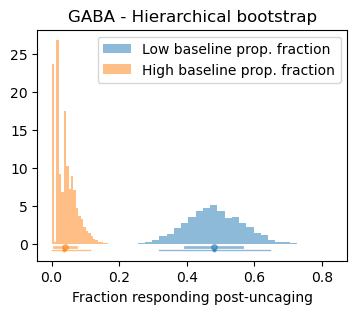

Glu


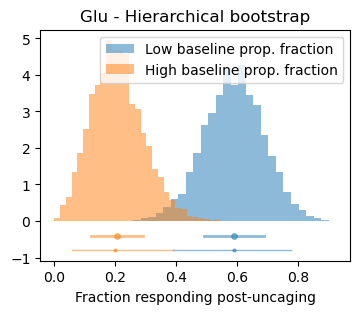

In [18]:
if 'prop_fraction_boot' in params['output_names']:

    boot_bins = 30

    for condition in params['comparison']:

        print( condition )
        
        result = results[condition]
        
        fig, ax = plt.subplots( figsize = (4, 3) )
        
        uplot.plot_boot(
            ax,
            result['fraction_low_boot'],
            result['fraction_low'],
            color = 'C0',
            bins = boot_bins,
            label = 'Low baseline prop. fraction'
        )
        
        uplot.plot_boot(
            ax,
            result['fraction_high_boot'],
            result['fraction_high'],
            color = 'C1',
            bins = boot_bins,
            label = 'High baseline prop. fraction'
        )
        
        plt.legend()
        plt.title( f'{condition} - Hierarchical bootstrap' )
        plt.xlabel( 'Fraction responding post-uncaging' )
        
        save_figure( params['output_names']['prop_fraction_boot'].format( condition = condition ) )

        plt.show()

##### Validation: Permutation distributions

GABA


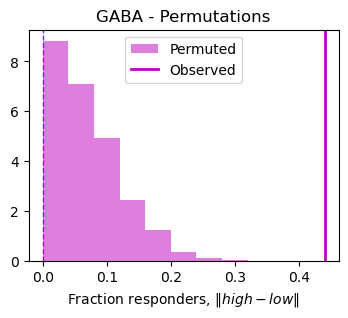

Glu


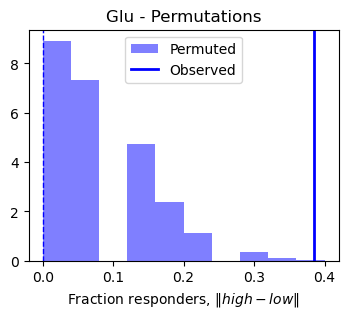

In [19]:
if 'prop_fraction_perm' in params['output_names']:

    perm_bins = np.arange( 0, 0.41, 0.04 )

    for condition in params['comparison']:

        print( condition )
        
        result = results[condition]
        
        fig, ax = plt.subplots( figsize = (4, 3) )
        
        uplot.plot_perm(
            ax,
            np.abs( result['fraction_diff_perm'] ),
            np.abs( result['fraction_diff'] ),
            color = helper.condition_colors[condition],
            bins = perm_bins
        )
        
        plt.legend()
        plt.title( f'{condition} - Permutations' )
        plt.xlabel( 'Fraction responders, $\|high - low\|$' )
        
        save_figure( params['output_names']['prop_fraction_perm'].format(
            condition = condition,
        ) )

        plt.show()

#### Plot

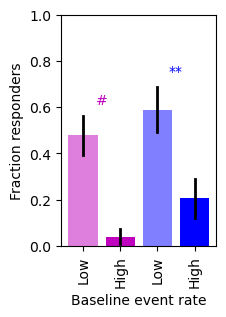

p-values:
    GABA    : 9.999000099990002e-05
    Glu     : 0.0011998800119988001


In [20]:
if 'prop_fraction' in params['output_names']:

    fig, ax = plt.subplots( figsize = (2, 3) )

    plot_prediction(
        ax,
        results,
        params['comparison'],
        **params['response_prediction_plot']
    )

    save_figure( params['output_names']['prop_fraction'] )

    plt.show()

    print( 'p-values:' )
    for condition, result in results.items():
        print( f'    {condition:8s}: {result["p_perm"]}' )

In [21]:
# Cache actual results for simulations later
results_actual_prop_frac = results.copy()

***

### Result: Stratify by overall baseline rate

In [22]:
results = analyze_prediction(
    results_responses,
    results_rates,
    'rate_all',
    **params['prediction']
)

p_table_data = []
for condition, result in results.items():
    p_table_entry = dict()
    p_table_entry['condition'] = condition
    p_table_entry['pvalue'] = result['p_perm']
    p_table_data.append( p_table_entry )
p_tables['overall_rate'] = pd.DataFrame( p_table_data )

GABA: 0.23333333333333334


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1485.93it/s]


Glu: 0.25


100%|██████████| 10000/10000 [00:06<00:00, 1523.36it/s]


#### Validation: Bootstrap distributions

GABA


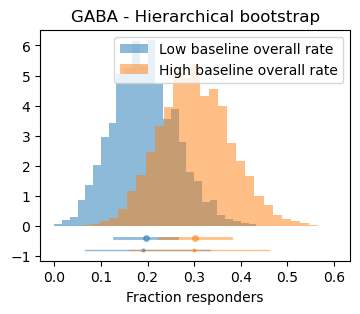

Glu


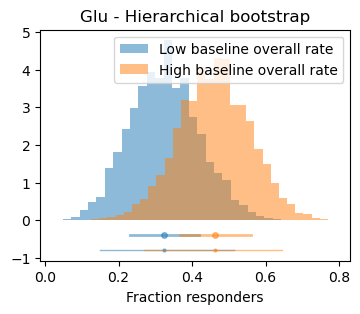

In [23]:
if 'overall_rate_boot' in params['output_names']:

    boot_bins = 30

    for condition in params['comparison']:

        print( condition )
        
        result = results[condition]
        
        fig, ax = plt.subplots( figsize = (4, 3) )
        
        uplot.plot_boot(
            ax,
            result['fraction_low_boot'],
            result['fraction_low'],
            color = 'C0',
            bins = boot_bins,
            label = 'Low baseline overall rate'
        )
        
        uplot.plot_boot(
            ax,
            result['fraction_high_boot'],
            result['fraction_high'],
            color = 'C1',
            bins = boot_bins,
            label = 'High baseline overall rate'
        )
        
        plt.legend()
        plt.title( f'{condition} - Hierarchical bootstrap' )
        plt.xlabel( 'Fraction responders' )
        
        save_figure( params['output_names']['overall_rate_boot'].format(
            condition = condition,
        ) )

        plt.show()

#### Validation: Permutation distributions

GABA


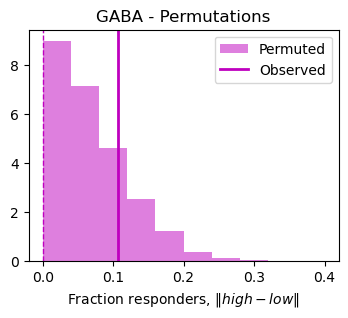

Glu


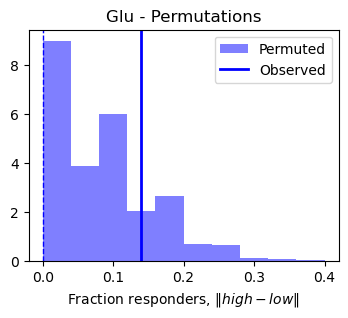

In [24]:
if 'overall_rate_perm' in params['output_names']:

    perm_bins = np.arange( 0, 0.41, 0.04 )

    for condition in params['comparison']:

        print( condition )
        
        result = results[condition]
        
        fig, ax = plt.subplots( figsize = (4, 3) )
        
        uplot.plot_perm(
            ax,
            np.abs( result['fraction_diff_perm'] ),
            np.abs( result['fraction_diff'] ),
            color = helper.condition_colors[condition],
            bins = perm_bins
        )
        
        plt.legend()
        plt.title( f'{condition} - Permutations' )
        plt.xlabel( 'Fraction responders, $\|high - low\|$' )
            
        save_figure( params['output_names']['overall_rate_perm'].format(
            condition = condition,
        ) )
        
        plt.show()

#### Plot

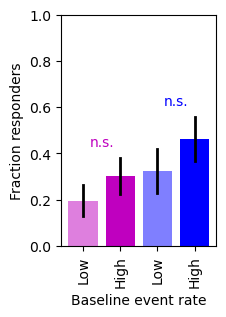

p-values:
    GABA    : 0.25437456254374563
    Glu     : 0.24677532246775322


In [25]:
if 'overall_rate' in params['output_names']:

    fig, ax = plt.subplots( figsize = (2, 3) )

    plot_prediction(
        ax,
        results,
        params['comparison'],
        **params['response_prediction_plot']
    )

    save_figure( params['output_names']['overall_rate'] )

    plt.show()

    print( 'p-values:' )
    for condition, result in results.items():
        print( f'    {condition:8s}: {result["p_perm"]}' )

In [26]:
results_actual_overall = results.copy()

***

### Save all results from unperturbed data

In [27]:
save_dict = {
    'events_considered_features': events_considered_features,
    'events_considered_response': events_considered_response,
    'params': params,
    'results': results,
}

save_data( params['output_names']['save_data'], **save_dict )

for k, table in p_tables.items():
    save_csv(
        params['output_names']['save_data'].format(
            condition = k,
        ),
        table
    )

***

### Validation analysis: Poisson null simulations

In [28]:
def _pois_hom(
        r: float,
        window: uevents.Window
    ) -> NDArray:
    """
    TODO
    """

    if r == 0:
        return np.array( [] )

    ret = []
    t_cur = window[0]
    while True:
        if t_cur >= window[1]:
            return np.array( ret )

        u = np.random.uniform()
        y = (-np.log( 1 - u )) / r
        t_cur += y
        ret.append( t_cur )

    # TODO Not reached
    return None

In [29]:
def surrogate_data_like(
        dfs: 'dict[str, DataFrame]',
        group_key: str,
        rate_windows: 'Optional[list[uevents.Window]]' = None,
        prop_model: str = 'independent',
        response_model: Optional[str] = None,
        t_key: str = 'start_time_rel',
        prop_key: str = 'mark_propTotal_bin',
        keep_keys: 'list[str]' = [],
    ) -> 'tuple[DataFrame, dict[str, DataFrame]]':
    
    if rate_windows is None:
        rate_windows = [
            (-60, 120),
        ]

    copy_keys = list( set(
        keep_keys
        + [
            params['group_key'],
            'is_uncage',
            'condition',
        ]
    ) )

    all_keys = list( set(
        copy_keys
        + [
            prop_key,
            t_key,
        ]
    ) )

    #
    
    ret_kinds = dict()

    if prop_model == 'independent':
        # Simulate each event type as an independent processes
        
        for kind, df in dfs.items():
            
            events_sim_data = dict()
            for k in all_keys:
                events_sim_data[k] = []

            # Cache response fraction distributions
            response_ratios = [None for _ in rate_windows[1:]]
            if response_model == 'choose_all':
                group_r_base = dict()
                for group, df_group in df.groupby( group_key ):
                    group_r_base[group] = uevents.rate_within( df_group['start_time_rel'], rate_windows[0] )

                if len( rate_windows ) < 2:
                    raise ValueError( 'Cannot compute response ratios with less than 2 windows' )

                for i_window, window in enumerate( rate_windows[1:] ):
                    response_ratios[i_window] = []
                    for group, df_group in df.groupby( group_key ):
                        if group_r_base[group] == 0.:
                            # Cannot compute ratio if baseline rate is 0
                            continue
                        cur_rate = uevents.rate_within( df_group['start_time_rel'], window )
                        response_ratios[i_window].append( cur_rate / group_r_base[group] )
                    response_ratios[i_window] = np.array( response_ratios[i_window] )

            # print( response_ratios )

            for group, df_group in df.groupby( group_key ):
                
                group_headers = df_group.iloc[0]

                # Cache current group's baseline rate
                r_base = uevents.rate_within( df_group['start_time_rel'], rate_windows[0] )

                for i_window, window in enumerate( rate_windows ):
                    
                    if response_model is None:
                        r_cur = uevents.rate_within( df_group['start_time_rel'], window )
                    elif response_model == 'choose_all':
                        if i_window == 0:
                            r_cur = r_base
                        else:
                            response_raito = np.random.choice( response_ratios[i_window - 1] )
                            r_cur = r_base * response_raito
                    ts_sim = _pois_hom( r_cur, window )

                    for t in ts_sim:
                        cur_datum = { k: None for k in events_sim_data.keys() }
                        cur_datum[t_key] = t
                        cur_datum[prop_key] = 1. if kind == 'prop' else 0.
                        for k in copy_keys:
                            cur_datum[k] = group_headers[k]
                        
                        # Grow current intermediates
                        for k, v in cur_datum.items():
                            events_sim_data[k].append( v )
            
            ret_kinds[kind] = pd.DataFrame( events_sim_data )
        
        ret_all = pd.concat(
            ret_kinds.values(),
            ignore_index = True
        )
    
    elif prop_model == 'combined':

        df_combined = pd.concat( dfs.values() )

        events_sim_data = dict()
        for k in all_keys:
            events_sim_data[k] = []

        for group, df_group in df_combined.groupby( group_key ):
            
            group_headers = df_group.iloc[0]
            
            if 'prop' in dfs:
                filter_cur = dfs['prop'][group_key] == group
                df_group_prop = dfs['prop'][filter_cur]
            else:
                df_group_prop = None

            for window in rate_windows:

                r_cur = uevents.rate_within( df_group['start_time_rel'], window )
                ts_sim = _pois_hom( r_cur, window )

                n_events_cur = np.sum( uevents.is_within( df_group['start_time_rel'], window ) )
                n_prop_cur = np.sum( uevents.is_within( df_group_prop['start_time_rel'], window ) )

                p_prop_cur = n_prop_cur / n_events_cur

                for t in ts_sim:
                    cur_datum = { k: None for k in events_sim_data.keys() }
                    cur_datum[t_key] = t
                    is_prop_cur = np.random.uniform() < p_prop_cur
                    cur_datum[prop_key] = 1. if is_prop_cur else 0.
                    for k in copy_keys:
                        cur_datum[k] = group_headers[k]
                    
                    # Grow current intermediates
                    for k, v in cur_datum.items():
                        events_sim_data[k].append( v )
        
        ret_all = pd.DataFrame( events_sim_data )

        filter_ret_prop = ret_all[prop_key] > 0.
        ret_kinds = {
            'prop': ret_all[filter_ret_prop].copy(),
            'static': ret_all[~filter_ret_prop].copy(),
        }

    return ret_all, ret_kinds

In [30]:
events_analyze_import = helper.load_analysis_events(
    analysis,
    extra_decorators = [],
    verbose = True
)

# This annotates the data with total propagation
events_analyze_import, _, _ = uevents.split_events_prop(
    events_analyze_import,
    threshold = params['prop_threshold'],
)
events_analyze_import, events_prop_import, events_no_prop_import = uevents.split_events_prop(
    events_analyze_import,
    threshold = params['prop_threshold'],
)

# Turn off resampling for the simulation phase, it isn't necessary
params_validation = params.copy()
params_validation['prediction']['n_boot'] = 0
params_validation['prediction']['n_perm'] = 0

fraction_diff_sim_prop_frac = dict()
fraction_diff_sim_prop_frac['GABA'] = []
fraction_diff_sim_prop_frac['Glu'] = []

fraction_diff_sim_overall = dict()
fraction_diff_sim_overall['GABA'] = []
fraction_diff_sim_overall['Glu'] = []

for i_perm in tqdm( range( params_validation['n_sim_validation'] ) ):

    # Generate surrogate data

    events_analyze_sim, events_kinds_sim = surrogate_data_like(
        {
            'prop': events_prop_import,
            'static': events_no_prop_import,
        },
        params_validation['group_key'],
        keep_keys = keep_keys,
        **params_validation['validation_sim']
    )
    events_prop_sim = events_kinds_sim['prop']

    ## Process surrogate data as above

    events_considered_features = events_analyze_sim.copy()
    events_considered_response = events_prop_sim.copy()

    filter_events_condition_features = events_considered_features['condition'].isin( conditions )
    filter_events_neighbor_features = events_considered_features['is_uncage'] == False
    filter_events_panel_features = filter_events_condition_features & filter_events_neighbor_features

    events_panel_features = events_considered_features[filter_events_panel_features]

    filter_events_condition_response = events_considered_response['condition'].isin( conditions )
    filter_events_neighbor_response = events_considered_response['is_uncage'] == False
    filter_events_panel_response = filter_events_condition_response & filter_events_neighbor_response

    events_panel_response = events_considered_response[filter_events_panel_response]

    results_responses = uevents.responders(
        events_panel_response,
        params_validation['group_key'],
        **params_validation['responders'],
    )
    results_features = uevents.features(
        events_panel_features,
        params_validation['group_key'],
        **params_validation['features'],
    )

    results_rates = uevents.rates(
        {
            'all': events_analyze,
            'prop': events_prop,
        },
        params_validation['group_key'],
        **params_validation['rates']
    )

    # Stratify by specified key

    results_prop_frac = analyze_prediction(
        results_responses,
        results_features,
        params_validation['prediction_mark'],
        verbose = False,
        **params_validation['prediction']
    )

    for condition, res in results_prop_frac.items():
        fraction_diff_sim_prop_frac[condition].append( res['fraction_diff'] )
    
    # Stratify by overall rate
        
    results_overall = analyze_prediction(
        results_responses,
        results_rates,
        'rate_all',
        verbose = False,
        **params_validation['prediction']
    )

    for condition, res in results_overall.items():
        fraction_diff_sim_overall[condition].append( res['fraction_diff'] )

Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 27.24it/s] 
Loading 20210629_CytoGp34f_S3_NoRuBi6_10stim-036Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 48/48 [00:01<00:00, 37.43it/s]
Loading 20200814_CytoGp35m_S2_RuBiGlu4_10stims-024Cycle00001_Ch1_cell-events.mat...: 100%|██████████| 56/56 [00:02<00:00, 27.42it/s] 



Experiment Glu
    Excluded cells: 177
    Included cells: 138


Experiment Control-Laser
    Excluded cells: 716
    Included cells: 99


Experiment GABA
    Excluded cells: 154
    Included cells: 164



  0%|          | 0/10000 [00:00<?, ?it/s]/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )
  0%|          | 1/10000 [00:01<4:53:42,  1.76s/it]/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )
  0%|          | 3/10000 [00:05<4:41:02,  1.69s/it]/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )
  0%|          | 4/10000 [00:06<4:34:31,  1.65s/it]/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )
  0%|          | 6/10000 [00:09<4:33:41,  1.64s/it]/Users/max/git/poskanzer-uncaging-pub-prep/python/uncaging/events.py:503: RuntimeWarning: Mean of empty slice
  val = np.nanmean( df_group_window[k] )


#### Result: Null effect for stratification by propagative fraction

f = 0.0154


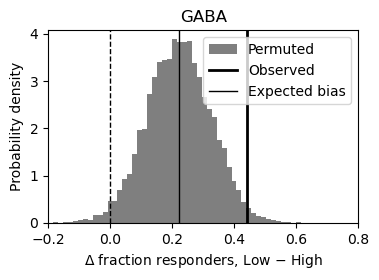

f = 0.0794


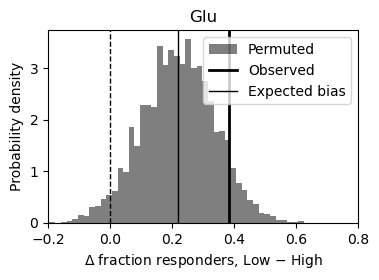

In [44]:
if 'response_diff_sim_prop_fraction' in params['output_names']:

    for condition, perm_vals in fraction_diff_sim_prop_frac.items():

        actual_val = results_actual_prop_frac[condition]['fraction_diff']

        #

        fig, ax = plt.subplots( figsize = (4, 2.5) )

        uplot.plot_perm(
            ax,
            perm_vals,
            actual_val,
            bins = 50,
            null = 0,
        )

        yl = plt.ylim()
        plt.plot(
            np.nanmean( perm_vals ) * np.array( [1, 1] ), yl,
            'k-',
            linewidth = 1,
            label = 'Expected bias',
        )

        f_above_cur = np.sum( perm_vals >= actual_val ) / np.sum( ~np.isnan( perm_vals ) )

        print( f'f = {f_above_cur}' )

        plt.xlim( -0.2, 0.8 )

        plt.title( f'{condition}' )

        plt.xlabel( '$\Delta$ fraction responders, Low $-$ High' )
        plt.ylabel( 'Probability density' )
        plt.legend()

        save_figure( params['output_names']['response_diff_sim_prop_fraction'].format(
            condition = condition,
        ) )

        plt.show()

#### Result: Null effect for stratification by overall rate

f = 0.8531


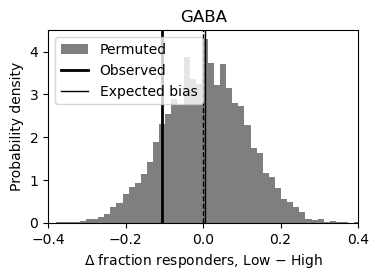

f = 0.8643


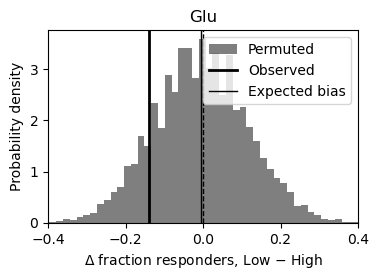

In [41]:
if 'response_diff_sim_overall_rate' in params['output_names']:

    for condition, perm_vals in fraction_diff_sim_overall.items():

        actual_val = results_actual_overall[condition]['fraction_diff']

        #

        fig, ax = plt.subplots( figsize = (4, 2.5) )

        uplot.plot_perm(
            ax,
            perm_vals,
            actual_val,
            bins = 50,
            null = 0,
        )

        yl = plt.ylim()
        plt.plot(
            np.nanmean( perm_vals ) * np.array( [1, 1] ), yl,
            'k-',
            linewidth = 1,
            label = 'Expected bias',
        )

        f_above_cur = np.sum( perm_vals >= actual_val ) / np.sum( ~np.isnan( perm_vals ) )

        print( f'f = {f_above_cur}' )

        plt.xlim( -0.4, 0.4 )

        plt.title( f'{condition}' )

        plt.xlabel( '$\Delta$ fraction responders, Low $-$ High' )
        plt.ylabel( 'Probability density' )
        plt.legend()

        save_figure( params['output_names']['response_diff_sim_overall_rate'].format(
            condition = condition,
        ) )

        plt.show()